In [1]:
import numpy as np
from matplotlib import pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

La función step nos permite alternar entre dos valores. Es simplemente la siguiente función partida:

$$
\text{step}_{a,b}(x) = \begin{cases} 
    0 & \text{si } x < a \\
    b & \text{si no}
    \end{cases}
$$

Donde $a$ es el umbral y $b$ es el valor que toma la función a partir de ese umbral.


Esto nos sirve para implementar un umbral, pero no nos permite tomar valores intermedios. Usemos para eso una _interpolación_.

_Smoothstep_ es una función sigmoidal que se utiliza generalmente para interpolar valores. La función es muy simple y se define como:

$$
\text{smoothstep}(x) = 3x^2 - 2x^3
$$

La función toma un valor entre 0 y 1 y devuelve un valor entre 0 y 1. La función es continua y suave, lo que la hace ideal para interpolaciones.
Es una implementación de la función de [interpolación de Hermite](https://en.wikipedia.org/wiki/Hermite_interpolation).

El problema que tiene esta funcion es que no es fácil de parametrizar en términos de la suavidad de la transición o el punto de inflexión. Para eso, intentemos construir una aproximación.

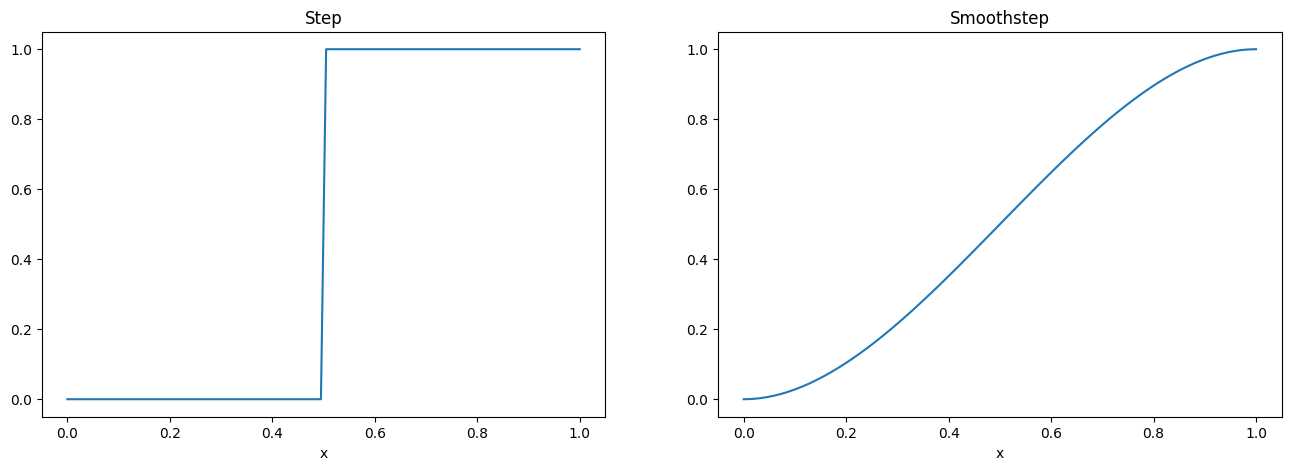

In [2]:
def step_ab(x, a, b):
    return np.where(x < a, 0, b)

step = lambda x: step_ab(x, a=0.5, b=1.0)

def smoothstep(x):
    return 3*x**2 - 2*x**3

x = np.linspace(0, 1, 100)
y = step(x)
y_smooth = smoothstep(x)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(x, y)
ax[0].set_title('Step')
ax[0].set_xlabel('x')

ax[1].plot(x, y_smooth)
ax[1].set_title('Smoothstep')
ax[1].set_xlabel('x')

plt.show()

Podemos pensar a $\text{smoothstep}$ como dos funciones exponenciales que están "pegadas" en un punto -el punto de inflexión- donde se unen de manera suave.

Armemos una función exponencial con parámetros para poder aproximarla:

$$
\displaystyle f_{a,p,s}(x) = p \cdot (\frac{x}{p})^{\frac{a}{s}}
$$

Construida de esta manera:

- Si $s\to0$ entonces $f_{a,p,s}(x) \to 0$ para todo $x$.
- Si $s=1$ entonces $\frac{a}{s}=a$
- $p$ escala y mueve la función, tal que la funcion queda definida entre $[0,p]$.
- $p \in [0,1]$
- $a$ al ser el exponente ayuda a cambiar la pendiente (o la suavidad) de la función.

Similarmente, podemos construir la función contraria (invertida y espejada) para que se peguen en un punto:

$$
\displaystyle g_{a,p,s}(x) = 1 - f_{a,{1-p},s}(1-x)
$$

Luego, nuestra aproximación a $\text{smoothstep}$ es:

$$
\displaystyle \text{smoothstep}'_{a,p,s}(x) = \begin{cases} 
    f_{a,p,s}(x) & \text{si } x \in [0,p] \\
    g_{a,p,s}(x) & \text{si } x \in \left(p,1\right]
    \end{cases}
$$

Así, $s$ nos ayuda a controlar la suavidad de la transición, $p$ nos ayuda a controlar el punto de inflexión y $a$ nos ayuda a controlar la pendiente de la transición.

El único problema que tienen estas definiciones es que para que $a$ haga que la función sea _step_ tiene que tender a infinito. Podemos arreglar esto cambiando la fracción de $\frac{a}{s}$ por $\frac{a}{1-s}$. Obtenemos:

$$
\displaystyle f_{a,p,s}(x) = p \cdot (\frac{x}{p})^{\frac{a}{1-s}}
$$

El resto de definiciones quedan iguales.

Aproximemos $a$, $s$ y $p$ para que $\text{smoothstep}'_{a,p,s}$ sea una buena aproximación de $\text{smoothstep}$. Para eso, definamos una función que mida el error cuadrático medio entre ambas funciones, y optimicemos los parámetros para encontrar un mínimo.

Error inicial: 3.11e+00
Error final: 2.40e-03
Parámetros óptimos: 
  a = 1.66
  p = 0.50
  s = 0.00


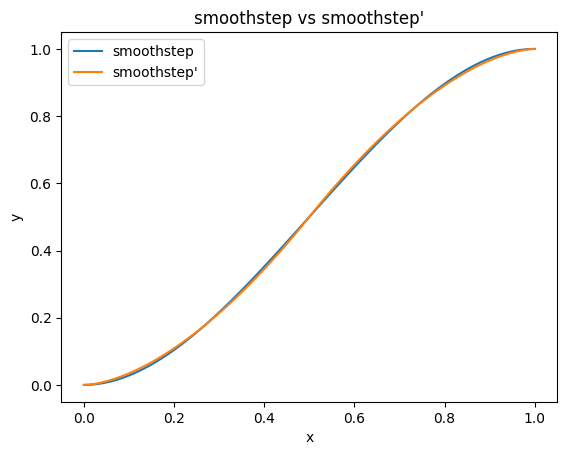

In [3]:
from scipy.optimize import minimize

def smoothstep_prima(x, a, p, s):
    def f(x, a, p, s):
        return (x / p)**(a / (1 - s)) * p
    
    def g(x, a, p, s): # f(1-x, a, 1-p, s)
        return 1 - ((1 - x) / (1 - p))**(a / (1 - s)) * (1 - p)
    
    return np.where(x >= p, g(x, a, p, s), f(x, a, p, s))

def error(args):
    a, p, s = args
    x = np.linspace(0, 1, 100)
    original = smoothstep(x)
    approx = smoothstep_prima(x, a, p, s)
    return np.sum((original - approx)**2) # MSE

result = minimize(error, method='L-BFGS-B',
                  # Estimación inicial
                  x0=[10,    # a
                      .5,    # p
                      0.02], # s
                  
                  # Límites de los parámetros
                  bounds=[(0, 50), # a
                          (0, 1),  # p
                          (0, 1)]  # s
                )

a_opt, p_opt, s_opt = result.x

print(f'Error inicial: {error([10, 0.5, 0.02]):.2e}')
print(f'Error final: {result.fun:.2e}')
print('Parámetros óptimos: ')
print(f'  a = {a_opt:.2f}')
print(f'  p = {p_opt:.2f}')
print(f'  s = {s_opt:.2f}')

x = np.linspace(0, 1, 100)
plt.plot(x, smoothstep(x), label='smoothstep')
plt.plot(x, smoothstep_prima(x, a_opt, p_opt, s_opt), label='smoothstep\'')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('smoothstep vs smoothstep\'')
plt.show()

De esta manera conseguimos una aproximación a smoothstep con un error de $2.4\times10^{-3}$, pero con la ventaja de que podemos controlar la suavidad de la transición y el punto de inflexión.

Grafiquemos las capacidades de esta función:

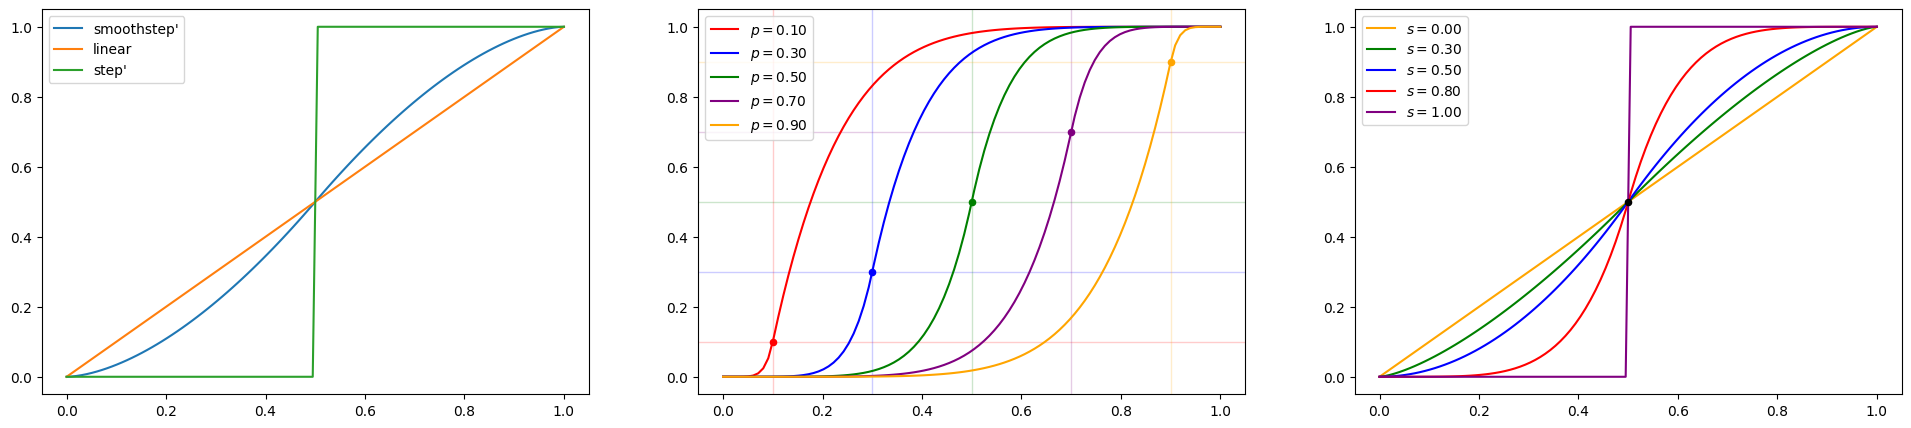

In [4]:
xs = np.linspace(0, 1, 100)

smoothstep_approx = lambda x: smoothstep_prima(x, a_opt, p_opt, s_opt)
linear_func = lambda x: smoothstep_prima(x, 1, p_opt, s=0)
step_approx = lambda x: smoothstep_prima(x, a_opt, p_opt, 1)

fig, ax = plt.subplots(1, 3, figsize=(24, 5))

funcs = [smoothstep_approx, linear_func, step_approx]

for func in funcs:
    ax[0].plot(xs, func(xs))

ax[0].legend(['smoothstep\'', 'linear', 'step\''])

a_0 = 1
s_0 = .85
ps = [0.1, 0.3, 0.5, 0.7, 0.9]
colors = ['red', 'blue', 'green', 'purple', 'orange']
ax[1].grid(False)

handles = []
labels = []
for p in ps:
    color = colors.pop(0)
    line, = ax[1].plot(xs, smoothstep_prima(xs, a_0, p, s_0), color=color)
    handles.append(line)
    labels.append(f'$p = {p:.2f}$')
    ax[1].axvline(p, color=color, linestyle='-', alpha=0.2, linewidth=1, zorder=-1)
    ax[1].axhline(p, color=color, linestyle='-', alpha=0.2, linewidth=1, zorder=-1)
    ax[1].scatter([p], [smoothstep_prima(p, a_0, p, s_0)], color=color, marker='o', s=20)

ax[1].legend(handles, labels)


a_0 = 1
p_0 = 0.5
ss = [0, 0.3, 0.5, 0.8, 1-1e-10]

colors = ['orange', 'green', 'blue', 'red', 'purple']

handles = []
labels = []
for s in ss:
    color = colors.pop(0)
    line, = ax[2].plot(xs, smoothstep_prima(xs, a_0, p_0, s), color=color)
    handles.append(line)
    labels.append(f'$s = {s:.2f}$')

ax[2].scatter(0.5,0.5, color='black', marker='o', s=20, zorder=2)
ax[2].legend(handles, labels)

plt.show()